# Fetching Dataset from Google Drive

### Importing Libraries

In [ ]:
import os
import time
import datetime
import tensorflow as tf
import matplotlib.pyplot as plt
from numpy.random import randint
from tensorflow.keras import Input
from numpy import load, zeros, ones
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import Conv2D, UpSampling2D, LeakyReLU, Activation
from tensorflow.keras.layers import Concatenate, Dropout, BatchNormalization

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6792559340383451103
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14619377664
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9198018141935980019
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


# Creating Functions

## Defining Discriminator

In [ ]:
def define_discriminator(image_shape):
	init = RandomNormal(stddev=0.02)

	in_src_image = Input(shape=image_shape)
	in_target_image = Input(shape=image_shape)

	merged = Concatenate()([in_src_image, in_target_image])

	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)

	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)

	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)

	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)

	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)

	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)

	model = Model([in_src_image, in_target_image], patch_out)

	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

## Defining Generator

In [ ]:
def define_generator(image_shape = (256, 256, 3)):
    init = RandomNormal(stddev=0.02)
    in_image = Input(shape=image_shape)

    g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
    g = BatchNormalization()(g, training=True)
    g3 = LeakyReLU(alpha=0.2)(g)

    g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g3)
    g = BatchNormalization()(g, training=True)
    g2 = LeakyReLU(alpha=0.2)(g)

    g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g2)
    g = BatchNormalization()(g, training=True)
    g1 = LeakyReLU(alpha=0.2)(g)

    for _ in range(6):
        g = Conv2D(256, (3,3), padding='same', kernel_initializer=init)(g1)
        g = BatchNormalization()(g, training=True)
        g = LeakyReLU(alpha=0.2)(g)

        g = Conv2D(256, (3,3), padding='same', kernel_initializer=init)(g)
        g = BatchNormalization()(g, training=True)

        g1 = Concatenate()([g, g1])

    g = UpSampling2D((2, 2))(g1)
    g = Conv2D(128, (1, 1), kernel_initializer=init)(g)
    g = Dropout(0.5)(g, training=True)
    g = Concatenate()([g, g2])
    g = BatchNormalization()(g, training=True)
    g = LeakyReLU(alpha=0.2)(g)

    g = UpSampling2D((2, 2))(g)
    g = Conv2D(64, (1, 1), kernel_initializer=init)(g)
    g = Dropout(0.5)(g, training=True)
    g = Concatenate()([g, g3])
    g = BatchNormalization()(g, training=True)
    g = LeakyReLU(alpha=0.2)(g)

    g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
    g = BatchNormalization()(g, training=True)
    out_image = Activation('tanh')(g)

    model = Model(in_image, out_image)
    return model

## Initializing GAN training

In [ ]:
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
	# define the source image
	in_src = Input(shape=image_shape)
	# connect the source image to the generator input
	gen_out = g_model(in_src)
	# connect the source input and generator output to the discriminator input
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and classification output
	model = Model(in_src, [dis_out, gen_out])
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
	return model

## Loading Real Samples

In [ ]:
def load_real_samples(filename):
	# load compressed arrays
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X2, X1]

## Generating Real Fake Samples

In [ ]:
def generate_real_samples(dataset, n_samples, patch_shape):
	# unpack dataset
	trainA, trainB = dataset
	# choose random instances
	ix = randint(0, trainA.shape[0], n_samples)
	# retrieve selected images
	X1, X2 = trainA[ix], trainB[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y

## Generating Fake Samples

In [ ]:
def generate_fake_samples(g_model, samples, patch_shape):
	# generate fake instance
	X = g_model.predict(samples)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

## Summarizing Training and Saving Model

In [ ]:
def summarize_performance(step, g_model, d_model, dataset, n_samples=3):
    # select a sample of input images
    [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
    # generate a batch of fake samples
    X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
    # scale all pixels from [-1,1] to [0,1]
    X_realA = (X_realA + 1) / 2.0
    X_realB = (X_realB + 1) / 2.0
    X_fakeB = (X_fakeB + 1) / 2.0
    # plot real source images
    plt.figure(figsize=(14, 14))
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + i)
        plt.axis('off')
        plt.title('Low-Light')
        plt.imshow(X_realA[i])
    # plot generated target image
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples + i)
        plt.axis('off')
        plt.title('Generated')
        plt.imshow(X_fakeB[i])
    # plot real target image
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples*2 + i)
        plt.axis('off')
        plt.title('Ground Truth')
        plt.imshow(X_realB[i])
    # save plot to file
    filename1 = step_output + 'plot_%06d.png' % (step+1)
    plt.savefig(filename1)
    plt.close()
    # save the generator model
    filename2 = model_output + 'gen_model_%06d.h5' % (step+1)
    g_model.save(filename2)
    # save the discriminator model
    filename3 = model_output + 'disc_model_%06d.h5' % (step+1)
    d_model.save(filename3)
    print('[.] Saved Step : %s' % (filename1))
    print('[.] Saved Model: %s' % (filename2))
    print('[.] Saved Model: %s' % (filename3))

## Training Function

In [ ]:
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=12):
    # determine the output square shape of the discriminator
    n_patch = d_model.output_shape[1]
    # unpack dataset
    trainA, trainB = dataset
    # calculate the number of batches per training epoch
    bat_per_epo = int(len(trainA) / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    print("[!] Number of steps {}".format(n_steps))
    print("[!] Saves model/step output at every {}".format(bat_per_epo * 1))
    # manually enumerate epochs
    for i in range(n_steps):
        start = time.time()
        # select a batch of real samples
        [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
        # generate a batch of fake samples
        X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
        # update discriminator for real samples
        d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
        # update discriminator for generated samples
        d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
        # update the generator
        g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
        # summarize performance
        time_taken = time.time() - start
        print(
            '[*] %06d, d1[%.3f] d2[%.3f] g[%06.3f] ---> time[%.2f], time_left[%.08s]'
                %
            (i+1, d_loss1, d_loss2, g_loss, time_taken, str(datetime.timedelta(seconds=((time_taken) * (n_steps - (i + 1))))).split('.')[0].zfill(8))
        )
        # summarize model performance
        if (i+1) % (bat_per_epo * 1) == 0:
            summarize_performance(i, g_model, d_model, dataset)

# Main Function

In [ ]:
import tensorflow as tf

# Enable GPU memory growth to prevent crashes
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("[INFO] GPU is available and being used.")
    except RuntimeError as e:
        print(e)
else:
    print("[WARNING] No GPU found, using CPU!")


[INFO] GPU is available and being used.


## Loading Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset = load_real_samples('/content/drive/MyDrive/PBL2/dataset.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)
image_shape = dataset[0].shape[1:]

Loaded (485, 256, 256, 3) (485, 256, 256, 3)


## Defining Models

In [ ]:
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
gan_model = define_gan(g_model, d_model, image_shape)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


## Creating model Directory and Calling Train Function

In [ ]:
dir = '/content/drive/MyDrive/PBL2/models'
fileName = 'Enhancement Model'
step_output = dir + fileName + "/Step Output/"
model_output = dir + fileName + "/Model Output/"
if fileName not in os.listdir(dir):
    os.mkdir(dir + fileName)
    os.mkdir(step_output)
    os.mkdir(model_output)

train(d_model, g_model, gan_model, dataset, n_batch=12)

[!] Number of steps 4000
[!] Saves model/step output at every 40
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
[*] 000001, d1[0.768] d2[0.482] g[72.877] ---> time[93.65], time_left[4 days, ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
[*] 000002, d1[0.578] d2[0.484] g[60.921] ---> time[1.86], time_left[02:04:04]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
[*] 000003, d1[0.540] d2[0.482] g[51.954] ---> time[1.59], time_left[01:45:37]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
[*] 000004, d1[0.522] d2[0.482] g[46.719] ---> time[1.61], time_left[01:47:25]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
[*] 000005, d1[0.512] d2[0.481] g[42.481] ---> time[1.61], time_left[01:47:22]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
[*] 000006, d1[0.506] d2[0.480] g[39.649] ---> time[1.58], time_left[01:45:23]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
[*] 000007, d1[0.500] d2[0.479] g[37.303] ---> time[1.59], time_left[01:45:55]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
[*] 000008, d1[0.497] d2[0.478] g[35.637] ---> time[1.88], time_left[0

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_000040.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_000040.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_000040.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
[*] 000041, d1[0.462] d2[0.460] g[23.173] ---> time[1.63], time_left[01:47:44]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
[*] 000042, d1[0.462] d2[0.459] g[22.982] ---> time[1.82], time_left[01:59:50]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
[*] 000043, d1[0.461] d2[0.458] g[22.848] ---> time[1.85], time_left[02:02:19]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
[*] 000044, d1[0.460] d2[0.458] g[22.669] ---> time[1.63], time_left[01:47:14]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
[*] 000045, d1[0.460] d2[0.457] g[22.540] ---> time[1.57], time_left[01:43:20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step
[*] 000046, d1[0.459] d2[0.457] g[22.393] ---> time[1.84], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_000080.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_000080.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_000080.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
[*] 000081, d1[0.443] d2[0.442] g[19.761] ---> time[1.57], time_left[01:42:16]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
[*] 000082, d1[0.443] d2[0.442] g[19.729] ---> time[1.82], time_left[01:58:55]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step
[*] 000083, d1[0.443] d2[0.442] g[19.685] ---> time[1.55], time_left[01:41:27]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
[*] 000084, d1[0.442] d2[0.441] g[19.626] ---> time[1.82], time_left[01:58:42]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
[*] 000085, d1[0.442] d2[0.441] g[19.542] ---> time[1.83], time_left[01:59:10]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
[*] 000086, d1[0.441] d2[0.441] g[19.474] ---> time[1.85], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_000120.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_000120.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_000120.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
[*] 000121, d1[0.431] d2[0.431] g[18.725] ---> time[1.83], time_left[01:58:24]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
[*] 000122, d1[0.431] d2[0.430] g[18.696] ---> time[1.56], time_left[01:40:42]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
[*] 000123, d1[0.431] d2[0.430] g[18.682] ---> time[1.86], time_left[02:00:27]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
[*] 000124, d1[0.430] d2[0.430] g[18.629] ---> time[1.84], time_left[01:58:39]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
[*] 000125, d1[0.430] d2[0.430] g[18.602] ---> time[1.57], time_left[01:41:20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
[*] 000126, d1[0.430] d2[0.429] g[18.576] ---> time[1.56], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_000160.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_000160.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_000160.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
[*] 000161, d1[0.423] d2[0.423] g[17.782] ---> time[1.83], time_left[01:57:07]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
[*] 000162, d1[0.423] d2[0.423] g[17.759] ---> time[1.56], time_left[01:39:31]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
[*] 000163, d1[0.423] d2[0.422] g[17.744] ---> time[1.82], time_left[01:56:37]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
[*] 000164, d1[0.422] d2[0.422] g[17.724] ---> time[1.82], time_left[01:56:36]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
[*] 000165, d1[0.422] d2[0.422] g[17.695] ---> time[1.56], time_left[01:39:50]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step
[*] 000166, d1[0.422] d2[0.422] g[17.670] ---> time[1.91], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_000200.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_000200.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_000200.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
[*] 000201, d1[0.417] d2[0.417] g[17.120] ---> time[1.57], time_left[01:39:05]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
[*] 000202, d1[0.417] d2[0.417] g[17.107] ---> time[1.56], time_left[01:38:59]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
[*] 000203, d1[0.417] d2[0.417] g[17.100] ---> time[1.84], time_left[01:56:34]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
[*] 000204, d1[0.417] d2[0.417] g[17.083] ---> time[1.59], time_left[01:40:48]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
[*] 000205, d1[0.417] d2[0.417] g[17.063] ---> time[1.57], time_left[01:39:15]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
[*] 000206, d1[0.417] d2[0.417] g[17.046] ---> time[1.57], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_000240.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_000240.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_000240.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
[*] 000241, d1[0.414] d2[0.414] g[16.722] ---> time[1.57], time_left[01:38:23]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
[*] 000242, d1[0.414] d2[0.414] g[16.716] ---> time[1.82], time_left[01:53:58]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
[*] 000243, d1[0.414] d2[0.414] g[16.711] ---> time[1.57], time_left[01:38:13]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
[*] 000244, d1[0.413] d2[0.414] g[16.712] ---> time[1.56], time_left[01:37:33]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
[*] 000245, d1[0.413] d2[0.413] g[16.703] ---> time[1.56], time_left[01:37:29]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
[*] 000246, d1[0.413] d2[0.413] g[16.697] ---> time[1.85], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_000280.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_000280.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_000280.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
[*] 000281, d1[0.411] d2[0.411] g[16.359] ---> time[1.83], time_left[01:53:38]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step
[*] 000282, d1[0.411] d2[0.411] g[16.346] ---> time[1.55], time_left[01:35:47]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
[*] 000283, d1[0.411] d2[0.411] g[16.340] ---> time[1.58], time_left[01:37:51]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
[*] 000284, d1[0.411] d2[0.411] g[16.333] ---> time[1.57], time_left[01:37:09]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
[*] 000285, d1[0.411] d2[0.411] g[16.321] ---> time[1.82], time_left[01:52:54]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
[*] 000286, d1[0.411] d2[0.411] g[16.315] ---> time[1.84], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_000320.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_000320.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_000320.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step
[*] 000321, d1[0.410] d2[0.410] g[16.094] ---> time[1.85], time_left[01:53:29]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
[*] 000322, d1[0.410] d2[0.410] g[16.083] ---> time[1.81], time_left[01:51:12]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
[*] 000323, d1[0.410] d2[0.410] g[16.073] ---> time[1.55], time_left[01:35:00]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
[*] 000324, d1[0.410] d2[0.410] g[16.069] ---> time[1.82], time_left[01:51:33]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
[*] 000325, d1[0.410] d2[0.410] g[16.059] ---> time[1.56], time_left[01:35:29]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
[*] 000326, d1[0.410] d2[0.410] g[16.050] ---> time[1.90], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_000360.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_000360.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_000360.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step
[*] 000361, d1[0.409] d2[0.409] g[15.863] ---> time[1.84], time_left[01:51:20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
[*] 000362, d1[0.409] d2[0.409] g[15.865] ---> time[1.83], time_left[01:50:54]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
[*] 000363, d1[0.409] d2[0.409] g[15.863] ---> time[1.83], time_left[01:50:57]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step
[*] 000364, d1[0.409] d2[0.409] g[15.852] ---> time[1.71], time_left[01:43:20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
[*] 000365, d1[0.409] d2[0.409] g[15.846] ---> time[1.85], time_left[01:52:22]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
[*] 000366, d1[0.409] d2[0.409] g[15.852] ---> time[1.58], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_000400.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_000400.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_000400.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step
[*] 000401, d1[0.409] d2[0.409] g[15.700] ---> time[1.85], time_left[01:51:06]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
[*] 000402, d1[0.409] d2[0.409] g[15.697] ---> time[1.83], time_left[01:49:28]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step
[*] 000403, d1[0.409] d2[0.409] g[15.696] ---> time[1.82], time_left[01:49:13]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
[*] 000404, d1[0.409] d2[0.409] g[15.691] ---> time[1.83], time_left[01:49:32]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
[*] 000405, d1[0.409] d2[0.409] g[15.684] ---> time[1.58], time_left[01:34:31]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
[*] 000406, d1[0.409] d2[0.409] g[15.675] ---> time[1.88], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_000440.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_000440.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_000440.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
[*] 000441, d1[0.408] d2[0.409] g[15.539] ---> time[1.58], time_left[01:33:27]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
[*] 000442, d1[0.408] d2[0.409] g[15.533] ---> time[1.82], time_left[01:47:52]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
[*] 000443, d1[0.408] d2[0.409] g[15.533] ---> time[1.55], time_left[01:31:37]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
[*] 000444, d1[0.408] d2[0.409] g[15.525] ---> time[1.56], time_left[01:32:26]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
[*] 000445, d1[0.408] d2[0.409] g[15.520] ---> time[1.84], time_left[01:48:56]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
[*] 000446, d1[0.408] d2[0.409] g[15.512] ---> time[1.60], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_000480.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_000480.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_000480.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
[*] 000481, d1[0.408] d2[0.409] g[15.402] ---> time[1.62], time_left[01:34:58]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
[*] 000482, d1[0.408] d2[0.409] g[15.403] ---> time[1.84], time_left[01:47:42]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
[*] 000483, d1[0.409] d2[0.409] g[15.408] ---> time[1.56], time_left[01:31:28]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
[*] 000484, d1[0.409] d2[0.409] g[15.402] ---> time[1.82], time_left[01:46:42]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step
[*] 000485, d1[0.409] d2[0.409] g[15.396] ---> time[1.89], time_left[01:50:46]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
[*] 000486, d1[0.409] d2[0.409] g[15.393] ---> time[1.57], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_000520.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_000520.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_000520.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
[*] 000521, d1[0.409] d2[0.409] g[15.310] ---> time[1.84], time_left[01:46:38]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
[*] 000522, d1[0.409] d2[0.409] g[15.303] ---> time[1.55], time_left[01:29:35]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
[*] 000523, d1[0.409] d2[0.409] g[15.300] ---> time[1.55], time_left[01:30:06]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
[*] 000524, d1[0.409] d2[0.409] g[15.299] ---> time[1.83], time_left[01:45:53]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
[*] 000525, d1[0.409] d2[0.409] g[15.293] ---> time[1.85], time_left[01:47:19]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step
[*] 000526, d1[0.409] d2[0.409] g[15.292] ---> time[1.85], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_000560.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_000560.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_000560.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
[*] 000561, d1[0.409] d2[0.409] g[15.216] ---> time[1.56], time_left[01:29:28]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step
[*] 000562, d1[0.409] d2[0.409] g[15.214] ---> time[1.85], time_left[01:45:48]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
[*] 000563, d1[0.409] d2[0.409] g[15.216] ---> time[1.86], time_left[01:46:29]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step
[*] 000564, d1[0.409] d2[0.409] g[15.215] ---> time[1.82], time_left[01:43:58]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
[*] 000565, d1[0.409] d2[0.409] g[15.216] ---> time[1.55], time_left[01:29:00]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
[*] 000566, d1[0.409] d2[0.409] g[15.212] ---> time[1.82], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_000600.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_000600.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_000600.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
[*] 000601, d1[0.409] d2[0.409] g[15.152] ---> time[1.82], time_left[01:43:05]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
[*] 000602, d1[0.409] d2[0.409] g[15.151] ---> time[1.82], time_left[01:43:15]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
[*] 000603, d1[0.409] d2[0.409] g[15.147] ---> time[1.56], time_left[01:28:05]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
[*] 000604, d1[0.409] d2[0.409] g[15.147] ---> time[1.83], time_left[01:43:42]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
[*] 000605, d1[0.409] d2[0.409] g[15.145] ---> time[1.85], time_left[01:44:55]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
[*] 000606, d1[0.409] d2[0.409] g[15.138] ---> time[1.76], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_000640.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_000640.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_000640.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
[*] 000641, d1[0.410] d2[0.410] g[15.079] ---> time[1.59], time_left[01:28:47]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
[*] 000642, d1[0.410] d2[0.410] g[15.076] ---> time[1.83], time_left[01:42:18]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
[*] 000643, d1[0.410] d2[0.410] g[15.077] ---> time[1.85], time_left[01:43:28]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
[*] 000644, d1[0.410] d2[0.410] g[15.076] ---> time[1.83], time_left[01:42:07]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
[*] 000645, d1[0.410] d2[0.410] g[15.070] ---> time[1.55], time_left[01:26:40]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
[*] 000646, d1[0.410] d2[0.410] g[15.066] ---> time[1.83], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_000680.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_000680.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_000680.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
[*] 000681, d1[0.410] d2[0.410] g[15.008] ---> time[1.58], time_left[01:27:21]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
[*] 000682, d1[0.410] d2[0.410] g[15.005] ---> time[1.82], time_left[01:40:37]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
[*] 000683, d1[0.410] d2[0.410] g[15.007] ---> time[1.56], time_left[01:26:18]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
[*] 000684, d1[0.410] d2[0.410] g[15.003] ---> time[1.82], time_left[01:40:29]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
[*] 000685, d1[0.410] d2[0.410] g[14.997] ---> time[1.84], time_left[01:41:31]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step
[*] 000686, d1[0.410] d2[0.410] g[14.992] ---> time[1.81], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_000720.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_000720.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_000720.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
[*] 000721, d1[0.411] d2[0.411] g[14.897] ---> time[1.84], time_left[01:40:41]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
[*] 000722, d1[0.411] d2[0.411] g[14.895] ---> time[1.82], time_left[01:39:33]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
[*] 000723, d1[0.411] d2[0.411] g[14.902] ---> time[1.85], time_left[01:40:59]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
[*] 000724, d1[0.411] d2[0.411] g[14.901] ---> time[1.84], time_left[01:40:23]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
[*] 000725, d1[0.411] d2[0.411] g[14.897] ---> time[1.85], time_left[01:40:47]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
[*] 000726, d1[0.411] d2[0.411] g[14.892] ---> time[1.83], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_000760.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_000760.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_000760.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
[*] 000761, d1[0.411] d2[0.411] g[14.852] ---> time[1.59], time_left[01:25:59]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
[*] 000762, d1[0.411] d2[0.411] g[14.852] ---> time[1.84], time_left[01:39:10]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
[*] 000763, d1[0.411] d2[0.411] g[14.851] ---> time[1.56], time_left[01:24:15]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
[*] 000764, d1[0.411] d2[0.411] g[14.852] ---> time[1.60], time_left[01:26:22]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
[*] 000765, d1[0.411] d2[0.411] g[14.848] ---> time[1.83], time_left[01:38:39]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
[*] 000766, d1[0.411] d2[0.411] g[14.852] ---> time[1.97], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_000800.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_000800.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_000800.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
[*] 000801, d1[0.412] d2[0.412] g[14.780] ---> time[1.59], time_left[01:24:56]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
[*] 000802, d1[0.412] d2[0.412] g[14.778] ---> time[1.86], time_left[01:38:54]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
[*] 000803, d1[0.412] d2[0.412] g[14.778] ---> time[1.83], time_left[01:37:42]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
[*] 000804, d1[0.412] d2[0.412] g[14.779] ---> time[1.82], time_left[01:37:05]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
[*] 000805, d1[0.412] d2[0.412] g[14.777] ---> time[1.82], time_left[01:37:06]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
[*] 000806, d1[0.412] d2[0.412] g[14.772] ---> time[1.88], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_000840.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_000840.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_000840.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
[*] 000841, d1[0.412] d2[0.412] g[14.732] ---> time[1.84], time_left[01:36:49]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
[*] 000842, d1[0.412] d2[0.412] g[14.731] ---> time[1.57], time_left[01:22:34]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
[*] 000843, d1[0.412] d2[0.412] g[14.727] ---> time[1.83], time_left[01:36:15]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
[*] 000844, d1[0.412] d2[0.412] g[14.723] ---> time[1.82], time_left[01:35:59]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
[*] 000845, d1[0.412] d2[0.412] g[14.726] ---> time[1.86], time_left[01:37:35]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
[*] 000846, d1[0.412] d2[0.412] g[14.723] ---> time[1.92], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_000880.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_000880.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_000880.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
[*] 000881, d1[0.413] d2[0.413] g[14.681] ---> time[1.84], time_left[01:35:39]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
[*] 000882, d1[0.413] d2[0.413] g[14.679] ---> time[1.87], time_left[01:36:59]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
[*] 000883, d1[0.413] d2[0.413] g[14.682] ---> time[1.86], time_left[01:36:24]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
[*] 000884, d1[0.413] d2[0.413] g[14.681] ---> time[1.56], time_left[01:21:02]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
[*] 000885, d1[0.413] d2[0.413] g[14.677] ---> time[1.82], time_left[01:34:40]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step
[*] 000886, d1[0.413] d2[0.413] g[14.675] ---> time[1.65], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_000920.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_000920.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_000920.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
[*] 000921, d1[0.413] d2[0.413] g[14.638] ---> time[1.59], time_left[01:21:30]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
[*] 000922, d1[0.413] d2[0.413] g[14.635] ---> time[1.56], time_left[01:19:49]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
[*] 000923, d1[0.413] d2[0.413] g[14.633] ---> time[1.82], time_left[01:33:15]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
[*] 000924, d1[0.413] d2[0.413] g[14.631] ---> time[1.56], time_left[01:20:00]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
[*] 000925, d1[0.413] d2[0.413] g[14.631] ---> time[1.82], time_left[01:33:05]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
[*] 000926, d1[0.413] d2[0.413] g[14.628] ---> time[1.86], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_000960.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_000960.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_000960.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
[*] 000961, d1[0.413] d2[0.414] g[14.583] ---> time[1.57], time_left[01:19:34]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
[*] 000962, d1[0.413] d2[0.414] g[14.582] ---> time[1.84], time_left[01:33:03]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step
[*] 000963, d1[0.413] d2[0.414] g[14.582] ---> time[1.60], time_left[01:21:07]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step
[*] 000964, d1[0.413] d2[0.414] g[14.580] ---> time[1.86], time_left[01:34:10]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
[*] 000965, d1[0.413] d2[0.414] g[14.581] ---> time[1.82], time_left[01:32:07]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
[*] 000966, d1[0.413] d2[0.414] g[14.583] ---> time[1.60], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_001000.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_001000.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_001000.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
[*] 001001, d1[0.414] d2[0.414] g[14.555] ---> time[1.57], time_left[01:18:32]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
[*] 001002, d1[0.414] d2[0.414] g[14.552] ---> time[1.57], time_left[01:18:26]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
[*] 001003, d1[0.414] d2[0.414] g[14.551] ---> time[1.83], time_left[01:31:20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
[*] 001004, d1[0.414] d2[0.414] g[14.550] ---> time[1.83], time_left[01:31:09]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
[*] 001005, d1[0.414] d2[0.414] g[14.547] ---> time[1.57], time_left[01:18:30]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step
[*] 001006, d1[0.414] d2[0.414] g[14.543] ---> time[1.87], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_001040.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_001040.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_001040.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
[*] 001041, d1[0.414] d2[0.414] g[14.498] ---> time[1.83], time_left[01:30:18]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
[*] 001042, d1[0.414] d2[0.414] g[14.497] ---> time[1.83], time_left[01:30:06]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
[*] 001043, d1[0.414] d2[0.414] g[14.497] ---> time[1.58], time_left[01:18:01]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
[*] 001044, d1[0.414] d2[0.414] g[14.495] ---> time[1.85], time_left[01:31:04]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
[*] 001045, d1[0.414] d2[0.414] g[14.497] ---> time[1.83], time_left[01:30:08]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
[*] 001046, d1[0.414] d2[0.414] g[14.493] ---> time[1.82], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_001080.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_001080.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_001080.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step
[*] 001081, d1[0.415] d2[0.415] g[14.475] ---> time[1.90], time_left[01:32:30]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step
[*] 001082, d1[0.415] d2[0.415] g[14.474] ---> time[1.87], time_left[01:31:07]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
[*] 001083, d1[0.415] d2[0.415] g[14.471] ---> time[1.56], time_left[01:15:45]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
[*] 001084, d1[0.415] d2[0.415] g[14.473] ---> time[1.57], time_left[01:16:19]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
[*] 001085, d1[0.415] d2[0.415] g[14.472] ---> time[1.57], time_left[01:16:09]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
[*] 001086, d1[0.415] d2[0.415] g[14.472] ---> time[1.83], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_001120.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_001120.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_001120.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
[*] 001121, d1[0.415] d2[0.415] g[14.461] ---> time[1.57], time_left[01:15:19]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
[*] 001122, d1[0.415] d2[0.415] g[14.458] ---> time[1.57], time_left[01:15:05]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
[*] 001123, d1[0.415] d2[0.415] g[14.456] ---> time[1.82], time_left[01:27:13]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
[*] 001124, d1[0.415] d2[0.415] g[14.456] ---> time[1.81], time_left[01:26:42]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
[*] 001125, d1[0.415] d2[0.415] g[14.453] ---> time[1.83], time_left[01:27:41]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step
[*] 001126, d1[0.415] d2[0.415] g[14.453] ---> time[1.70], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_001160.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_001160.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_001160.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
[*] 001161, d1[0.415] d2[0.415] g[14.411] ---> time[1.83], time_left[01:26:24]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
[*] 001162, d1[0.415] d2[0.415] g[14.412] ---> time[1.84], time_left[01:27:05]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step
[*] 001163, d1[0.415] d2[0.415] g[14.411] ---> time[1.85], time_left[01:27:24]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
[*] 001164, d1[0.415] d2[0.416] g[14.413] ---> time[1.82], time_left[01:25:51]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
[*] 001165, d1[0.415] d2[0.416] g[14.411] ---> time[1.83], time_left[01:26:20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
[*] 001166, d1[0.415] d2[0.416] g[14.408] ---> time[1.60], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_001200.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_001200.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_001200.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step
[*] 001201, d1[0.416] d2[0.416] g[14.379] ---> time[1.64], time_left[01:16:19]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
[*] 001202, d1[0.416] d2[0.416] g[14.377] ---> time[1.83], time_left[01:25:17]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
[*] 001203, d1[0.416] d2[0.416] g[14.377] ---> time[1.57], time_left[01:13:16]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
[*] 001204, d1[0.416] d2[0.416] g[14.374] ---> time[1.82], time_left[01:24:59]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
[*] 001205, d1[0.416] d2[0.416] g[14.377] ---> time[1.55], time_left[01:12:22]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
[*] 001206, d1[0.416] d2[0.416] g[14.374] ---> time[1.90], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_001240.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_001240.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_001240.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
[*] 001241, d1[0.416] d2[0.416] g[14.353] ---> time[1.60], time_left[01:13:43]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
[*] 001242, d1[0.416] d2[0.416] g[14.352] ---> time[1.86], time_left[01:25:21]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
[*] 001243, d1[0.416] d2[0.416] g[14.351] ---> time[1.60], time_left[01:13:40]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
[*] 001244, d1[0.416] d2[0.416] g[14.350] ---> time[1.56], time_left[01:11:52]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
[*] 001245, d1[0.416] d2[0.416] g[14.348] ---> time[1.55], time_left[01:11:15]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
[*] 001246, d1[0.416] d2[0.416] g[14.347] ---> time[1.57], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_001280.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_001280.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_001280.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
[*] 001281, d1[0.417] d2[0.417] g[14.330] ---> time[1.64], time_left[01:14:27]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
[*] 001282, d1[0.417] d2[0.417] g[14.328] ---> time[1.59], time_left[01:12:04]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
[*] 001283, d1[0.417] d2[0.417] g[14.328] ---> time[1.82], time_left[01:22:13]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
[*] 001284, d1[0.417] d2[0.417] g[14.328] ---> time[1.82], time_left[01:22:25]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
[*] 001285, d1[0.417] d2[0.417] g[14.329] ---> time[1.85], time_left[01:23:47]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
[*] 001286, d1[0.417] d2[0.417] g[14.329] ---> time[1.86], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_001320.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_001320.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_001320.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
[*] 001321, d1[0.417] d2[0.417] g[14.301] ---> time[1.82], time_left[01:21:18]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
[*] 001322, d1[0.417] d2[0.417] g[14.299] ---> time[1.82], time_left[01:21:23]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
[*] 001323, d1[0.417] d2[0.417] g[14.300] ---> time[1.55], time_left[01:09:15]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
[*] 001324, d1[0.417] d2[0.417] g[14.299] ---> time[1.59], time_left[01:10:51]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
[*] 001325, d1[0.417] d2[0.417] g[14.300] ---> time[1.84], time_left[01:22:07]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
[*] 001326, d1[0.417] d2[0.417] g[14.300] ---> time[1.83], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_001360.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_001360.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_001360.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step
[*] 001361, d1[0.417] d2[0.417] g[14.281] ---> time[1.87], time_left[01:22:16]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
[*] 001362, d1[0.417] d2[0.417] g[14.281] ---> time[1.56], time_left[01:08:22]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
[*] 001363, d1[0.417] d2[0.417] g[14.278] ---> time[1.84], time_left[01:20:51]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
[*] 001364, d1[0.417] d2[0.417] g[14.277] ---> time[1.85], time_left[01:21:07]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
[*] 001365, d1[0.417] d2[0.417] g[14.277] ---> time[1.84], time_left[01:20:35]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step
[*] 001366, d1[0.417] d2[0.417] g[14.278] ---> time[1.62], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_001400.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_001400.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_001400.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
[*] 001401, d1[0.418] d2[0.418] g[14.264] ---> time[1.83], time_left[01:19:04]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
[*] 001402, d1[0.418] d2[0.418] g[14.264] ---> time[1.56], time_left[01:07:26]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
[*] 001403, d1[0.418] d2[0.418] g[14.264] ---> time[1.57], time_left[01:07:46]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
[*] 001404, d1[0.418] d2[0.418] g[14.264] ---> time[1.58], time_left[01:08:22]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
[*] 001405, d1[0.418] d2[0.418] g[14.265] ---> time[1.84], time_left[01:19:43]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
[*] 001406, d1[0.418] d2[0.418] g[14.264] ---> time[1.60], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_001440.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_001440.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_001440.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
[*] 001441, d1[0.418] d2[0.418] g[14.251] ---> time[1.83], time_left[01:18:08]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
[*] 001442, d1[0.418] d2[0.418] g[14.250] ---> time[1.84], time_left[01:18:32]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
[*] 001443, d1[0.418] d2[0.418] g[14.248] ---> time[1.59], time_left[01:07:53]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
[*] 001444, d1[0.418] d2[0.418] g[14.252] ---> time[1.57], time_left[01:06:43]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
[*] 001445, d1[0.418] d2[0.418] g[14.252] ---> time[1.56], time_left[01:06:27]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
[*] 001446, d1[0.418] d2[0.418] g[14.251] ---> time[1.59], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_001480.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_001480.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_001480.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
[*] 001481, d1[0.418] d2[0.418] g[14.232] ---> time[1.82], time_left[01:16:31]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
[*] 001482, d1[0.418] d2[0.418] g[14.230] ---> time[1.82], time_left[01:16:31]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
[*] 001483, d1[0.418] d2[0.418] g[14.228] ---> time[1.57], time_left[01:05:40]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
[*] 001484, d1[0.418] d2[0.418] g[14.227] ---> time[1.81], time_left[01:15:59]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
[*] 001485, d1[0.418] d2[0.418] g[14.226] ---> time[1.82], time_left[01:16:25]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step
[*] 001486, d1[0.418] d2[0.418] g[14.227] ---> time[2.12], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_001520.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_001520.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_001520.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
[*] 001521, d1[0.419] d2[0.419] g[14.208] ---> time[1.56], time_left[01:04:34]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
[*] 001522, d1[0.419] d2[0.419] g[14.207] ---> time[1.81], time_left[01:14:47]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
[*] 001523, d1[0.419] d2[0.419] g[14.206] ---> time[1.88], time_left[01:17:29]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
[*] 001524, d1[0.419] d2[0.419] g[14.204] ---> time[1.61], time_left[01:06:21]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
[*] 001525, d1[0.419] d2[0.419] g[14.203] ---> time[1.84], time_left[01:16:04]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
[*] 001526, d1[0.419] d2[0.419] g[14.201] ---> time[1.82], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_001560.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_001560.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_001560.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
[*] 001561, d1[0.419] d2[0.419] g[14.178] ---> time[1.68], time_left[01:08:15]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
[*] 001562, d1[0.419] d2[0.419] g[14.178] ---> time[1.55], time_left[01:02:51]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
[*] 001563, d1[0.419] d2[0.419] g[14.177] ---> time[1.55], time_left[01:03:01]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
[*] 001564, d1[0.419] d2[0.419] g[14.174] ---> time[1.58], time_left[01:03:58]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
[*] 001565, d1[0.419] d2[0.419] g[14.175] ---> time[1.82], time_left[01:13:47]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
[*] 001566, d1[0.419] d2[0.419] g[14.174] ---> time[1.60], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_001600.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_001600.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_001600.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
[*] 001601, d1[0.419] d2[0.419] g[14.150] ---> time[1.84], time_left[01:13:27]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
[*] 001602, d1[0.419] d2[0.419] g[14.151] ---> time[1.82], time_left[01:12:51]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
[*] 001603, d1[0.419] d2[0.419] g[14.149] ---> time[1.82], time_left[01:12:49]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
[*] 001604, d1[0.419] d2[0.419] g[14.149] ---> time[1.83], time_left[01:13:06]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
[*] 001605, d1[0.419] d2[0.419] g[14.151] ---> time[1.85], time_left[01:13:39]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
[*] 001606, d1[0.419] d2[0.419] g[14.150] ---> time[1.88], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_001640.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_001640.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_001640.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
[*] 001641, d1[0.419] d2[0.420] g[14.113] ---> time[1.57], time_left[01:01:39]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
[*] 001642, d1[0.419] d2[0.420] g[14.111] ---> time[1.87], time_left[01:13:23]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
[*] 001643, d1[0.420] d2[0.420] g[14.110] ---> time[1.86], time_left[01:12:52]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
[*] 001644, d1[0.420] d2[0.420] g[14.112] ---> time[1.86], time_left[01:13:11]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
[*] 001645, d1[0.420] d2[0.420] g[14.110] ---> time[1.82], time_left[01:11:30]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
[*] 001646, d1[0.420] d2[0.420] g[14.111] ---> time[1.84], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_001680.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_001680.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_001680.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
[*] 001681, d1[0.420] d2[0.420] g[14.096] ---> time[1.58], time_left[01:01:11]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
[*] 001682, d1[0.420] d2[0.420] g[14.095] ---> time[1.56], time_left[01:00:15]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
[*] 001683, d1[0.420] d2[0.420] g[14.093] ---> time[1.56], time_left[01:00:07]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step
[*] 001684, d1[0.420] d2[0.420] g[14.091] ---> time[1.59], time_left[01:01:27]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
[*] 001685, d1[0.420] d2[0.420] g[14.091] ---> time[1.56], time_left[01:00:17]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
[*] 001686, d1[0.420] d2[0.420] g[14.090] ---> time[1.84], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_001720.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_001720.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_001720.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
[*] 001721, d1[0.420] d2[0.420] g[14.065] ---> time[1.84], time_left[01:09:47]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
[*] 001722, d1[0.420] d2[0.420] g[14.065] ---> time[1.84], time_left[01:09:59]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step
[*] 001723, d1[0.420] d2[0.420] g[14.064] ---> time[1.60], time_left[01:00:54]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
[*] 001724, d1[0.420] d2[0.420] g[14.064] ---> time[1.57], time_left[00:59:41]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
[*] 001725, d1[0.420] d2[0.420] g[14.065] ---> time[1.82], time_left[01:09:03]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
[*] 001726, d1[0.420] d2[0.420] g[14.066] ---> time[1.61], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_001760.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_001760.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_001760.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
[*] 001761, d1[0.420] d2[0.420] g[14.050] ---> time[1.65], time_left[01:01:32]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
[*] 001762, d1[0.420] d2[0.420] g[14.049] ---> time[1.57], time_left[00:58:29]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
[*] 001763, d1[0.420] d2[0.420] g[14.048] ---> time[1.56], time_left[00:58:07]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
[*] 001764, d1[0.420] d2[0.420] g[14.047] ---> time[1.82], time_left[01:07:56]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
[*] 001765, d1[0.420] d2[0.421] g[14.048] ---> time[1.58], time_left[00:58:54]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
[*] 001766, d1[0.420] d2[0.421] g[14.047] ---> time[1.83], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_001800.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_001800.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_001800.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
[*] 001801, d1[0.421] d2[0.421] g[14.020] ---> time[1.61], time_left[00:59:07]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
[*] 001802, d1[0.421] d2[0.421] g[14.020] ---> time[1.57], time_left[00:57:38]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
[*] 001803, d1[0.421] d2[0.421] g[14.019] ---> time[1.84], time_left[01:07:15]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
[*] 001804, d1[0.421] d2[0.421] g[14.018] ---> time[1.59], time_left[00:58:21]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
[*] 001805, d1[0.421] d2[0.421] g[14.019] ---> time[1.61], time_left[00:58:55]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
[*] 001806, d1[0.421] d2[0.421] g[14.018] ---> time[1.56], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_001840.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_001840.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_001840.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
[*] 001841, d1[0.421] d2[0.421] g[14.015] ---> time[1.88], time_left[01:07:33]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step
[*] 001842, d1[0.421] d2[0.421] g[14.013] ---> time[1.90], time_left[01:08:23]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
[*] 001843, d1[0.421] d2[0.421] g[14.013] ---> time[1.57], time_left[00:56:17]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
[*] 001844, d1[0.421] d2[0.421] g[14.013] ---> time[1.84], time_left[01:06:03]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
[*] 001845, d1[0.421] d2[0.421] g[14.012] ---> time[1.83], time_left[01:05:39]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
[*] 001846, d1[0.421] d2[0.421] g[14.012] ---> time[1.89], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_001880.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_001880.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_001880.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
[*] 001881, d1[0.421] d2[0.421] g[13.999] ---> time[1.84], time_left[01:04:53]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
[*] 001882, d1[0.421] d2[0.421] g[13.999] ---> time[1.57], time_left[00:55:23]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
[*] 001883, d1[0.421] d2[0.421] g[13.999] ---> time[1.83], time_left[01:04:33]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
[*] 001884, d1[0.421] d2[0.421] g[13.999] ---> time[1.83], time_left[01:04:42]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
[*] 001885, d1[0.421] d2[0.421] g[14.000] ---> time[1.86], time_left[01:05:30]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
[*] 001886, d1[0.421] d2[0.421] g[13.999] ---> time[1.92], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_001920.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_001920.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_001920.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
[*] 001921, d1[0.422] d2[0.422] g[13.979] ---> time[1.68], time_left[00:58:06]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
[*] 001922, d1[0.422] d2[0.422] g[13.979] ---> time[1.61], time_left[00:55:44]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
[*] 001923, d1[0.422] d2[0.422] g[13.977] ---> time[1.82], time_left[01:02:52]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
[*] 001924, d1[0.422] d2[0.422] g[13.977] ---> time[1.83], time_left[01:03:13]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
[*] 001925, d1[0.422] d2[0.422] g[13.976] ---> time[1.83], time_left[01:03:11]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step
[*] 001926, d1[0.422] d2[0.422] g[13.974] ---> time[1.88], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_001960.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_001960.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_001960.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
[*] 001961, d1[0.422] d2[0.422] g[13.950] ---> time[1.82], time_left[01:01:54]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
[*] 001962, d1[0.422] d2[0.422] g[13.949] ---> time[1.56], time_left[00:52:55]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
[*] 001963, d1[0.422] d2[0.422] g[13.950] ---> time[1.57], time_left[00:53:18]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
[*] 001964, d1[0.422] d2[0.422] g[13.949] ---> time[1.55], time_left[00:52:36]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step
[*] 001965, d1[0.422] d2[0.422] g[13.948] ---> time[1.61], time_left[00:54:27]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
[*] 001966, d1[0.422] d2[0.422] g[13.946] ---> time[1.85], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_002000.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_002000.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_002000.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
[*] 002001, d1[0.422] d2[0.422] g[13.932] ---> time[1.84], time_left[01:01:20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
[*] 002002, d1[0.422] d2[0.422] g[13.933] ---> time[1.83], time_left[01:00:54]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step
[*] 002003, d1[0.422] d2[0.422] g[13.932] ---> time[1.62], time_left[00:53:59]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
[*] 002004, d1[0.422] d2[0.422] g[13.933] ---> time[1.57], time_left[00:52:04]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
[*] 002005, d1[0.422] d2[0.422] g[13.932] ---> time[1.57], time_left[00:52:09]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
[*] 002006, d1[0.422] d2[0.422] g[13.931] ---> time[1.56], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_002040.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_002040.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_002040.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
[*] 002041, d1[0.422] d2[0.422] g[13.916] ---> time[1.83], time_left[00:59:43]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
[*] 002042, d1[0.422] d2[0.422] g[13.916] ---> time[1.82], time_left[00:59:29]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
[*] 002043, d1[0.422] d2[0.422] g[13.915] ---> time[1.55], time_left[00:50:42]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
[*] 002044, d1[0.422] d2[0.422] g[13.915] ---> time[1.82], time_left[00:59:13]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
[*] 002045, d1[0.422] d2[0.422] g[13.914] ---> time[1.56], time_left[00:50:52]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
[*] 002046, d1[0.422] d2[0.422] g[13.915] ---> time[1.58], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_002080.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_002080.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_002080.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
[*] 002081, d1[0.423] d2[0.423] g[13.906] ---> time[1.83], time_left[00:58:25]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
[*] 002082, d1[0.423] d2[0.423] g[13.906] ---> time[1.55], time_left[00:49:42]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
[*] 002083, d1[0.423] d2[0.423] g[13.906] ---> time[1.55], time_left[00:49:34]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
[*] 002084, d1[0.423] d2[0.423] g[13.905] ---> time[1.60], time_left[00:50:59]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
[*] 002085, d1[0.423] d2[0.423] g[13.905] ---> time[1.60], time_left[00:50:58]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
[*] 002086, d1[0.423] d2[0.423] g[13.904] ---> time[1.56], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_002120.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_002120.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_002120.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
[*] 002121, d1[0.423] d2[0.423] g[13.891] ---> time[1.57], time_left[00:49:19]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
[*] 002122, d1[0.423] d2[0.423] g[13.891] ---> time[1.63], time_left[00:50:54]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
[*] 002123, d1[0.423] d2[0.423] g[13.892] ---> time[1.84], time_left[00:57:41]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
[*] 002124, d1[0.423] d2[0.423] g[13.892] ---> time[1.82], time_left[00:57:03]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
[*] 002125, d1[0.423] d2[0.423] g[13.892] ---> time[1.82], time_left[00:56:53]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step
[*] 002126, d1[0.423] d2[0.423] g[13.892] ---> time[1.82], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_002160.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_002160.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_002160.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
[*] 002161, d1[0.423] d2[0.423] g[13.876] ---> time[1.59], time_left[00:48:51]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
[*] 002162, d1[0.423] d2[0.423] g[13.875] ---> time[1.58], time_left[00:48:23]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
[*] 002163, d1[0.423] d2[0.423] g[13.874] ---> time[1.56], time_left[00:47:45]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
[*] 002164, d1[0.423] d2[0.423] g[13.874] ---> time[1.56], time_left[00:47:39]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
[*] 002165, d1[0.423] d2[0.423] g[13.873] ---> time[1.57], time_left[00:47:59]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
[*] 002166, d1[0.423] d2[0.423] g[13.872] ---> time[1.82], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_002200.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_002200.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_002200.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step
[*] 002201, d1[0.423] d2[0.423] g[13.859] ---> time[1.59], time_left[00:47:41]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
[*] 002202, d1[0.423] d2[0.423] g[13.858] ---> time[1.55], time_left[00:46:29]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
[*] 002203, d1[0.423] d2[0.423] g[13.858] ---> time[1.59], time_left[00:47:36]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
[*] 002204, d1[0.423] d2[0.423] g[13.858] ---> time[1.60], time_left[00:47:53]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
[*] 002205, d1[0.423] d2[0.423] g[13.857] ---> time[1.83], time_left[00:54:38]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
[*] 002206, d1[0.423] d2[0.423] g[13.857] ---> time[1.84], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_002240.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_002240.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_002240.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
[*] 002241, d1[0.424] d2[0.424] g[13.845] ---> time[1.61], time_left[00:47:20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
[*] 002242, d1[0.424] d2[0.424] g[13.844] ---> time[1.85], time_left[00:54:12]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
[*] 002243, d1[0.424] d2[0.424] g[13.843] ---> time[1.57], time_left[00:45:55]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
[*] 002244, d1[0.424] d2[0.424] g[13.842] ---> time[1.83], time_left[00:53:27]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
[*] 002245, d1[0.424] d2[0.424] g[13.843] ---> time[1.84], time_left[00:53:54]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step
[*] 002246, d1[0.424] d2[0.424] g[13.842] ---> time[1.65], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_002280.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_002280.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_002280.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step
[*] 002281, d1[0.424] d2[0.424] g[13.830] ---> time[1.84], time_left[00:52:44]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
[*] 002282, d1[0.424] d2[0.424] g[13.830] ---> time[1.57], time_left[00:44:57]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
[*] 002283, d1[0.424] d2[0.424] g[13.830] ---> time[1.58], time_left[00:45:07]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
[*] 002284, d1[0.424] d2[0.424] g[13.829] ---> time[1.56], time_left[00:44:35]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
[*] 002285, d1[0.424] d2[0.424] g[13.829] ---> time[1.56], time_left[00:44:38]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
[*] 002286, d1[0.424] d2[0.424] g[13.828] ---> time[1.60], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_002320.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_002320.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_002320.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
[*] 002321, d1[0.424] d2[0.424] g[13.815] ---> time[1.57], time_left[00:43:56]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
[*] 002322, d1[0.424] d2[0.424] g[13.814] ---> time[1.56], time_left[00:43:33]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
[*] 002323, d1[0.424] d2[0.424] g[13.813] ---> time[1.56], time_left[00:43:43]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step
[*] 002324, d1[0.424] d2[0.424] g[13.813] ---> time[1.85], time_left[00:51:35]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
[*] 002325, d1[0.424] d2[0.424] g[13.812] ---> time[1.60], time_left[00:44:48]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
[*] 002326, d1[0.424] d2[0.424] g[13.811] ---> time[1.58], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_002360.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_002360.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_002360.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step
[*] 002361, d1[0.424] d2[0.424] g[13.796] ---> time[1.68], time_left[00:45:52]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
[*] 002362, d1[0.424] d2[0.424] g[13.795] ---> time[1.82], time_left[00:49:42]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
[*] 002363, d1[0.424] d2[0.424] g[13.796] ---> time[1.57], time_left[00:42:55]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
[*] 002364, d1[0.424] d2[0.424] g[13.795] ---> time[1.57], time_left[00:42:41]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
[*] 002365, d1[0.424] d2[0.424] g[13.795] ---> time[1.83], time_left[00:50:00]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step
[*] 002366, d1[0.424] d2[0.424] g[13.794] ---> time[1.85], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_002400.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_002400.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_002400.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
[*] 002401, d1[0.424] d2[0.425] g[13.784] ---> time[1.54], time_left[00:41:05]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
[*] 002402, d1[0.425] d2[0.425] g[13.783] ---> time[1.83], time_left[00:48:37]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
[*] 002403, d1[0.425] d2[0.425] g[13.782] ---> time[1.56], time_left[00:41:29]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
[*] 002404, d1[0.425] d2[0.425] g[13.782] ---> time[1.56], time_left[00:41:29]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
[*] 002405, d1[0.425] d2[0.425] g[13.783] ---> time[1.83], time_left[00:48:45]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step
[*] 002406, d1[0.425] d2[0.425] g[13.782] ---> time[1.60], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_002440.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_002440.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_002440.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
[*] 002441, d1[0.425] d2[0.425] g[13.761] ---> time[1.65], time_left[00:42:51]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step
[*] 002442, d1[0.425] d2[0.425] g[13.759] ---> time[1.60], time_left[00:41:40]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step
[*] 002443, d1[0.425] d2[0.425] g[13.759] ---> time[1.84], time_left[00:47:49]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
[*] 002444, d1[0.425] d2[0.425] g[13.762] ---> time[1.58], time_left[00:40:59]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
[*] 002445, d1[0.425] d2[0.425] g[13.762] ---> time[1.82], time_left[00:47:09]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step
[*] 002446, d1[0.425] d2[0.425] g[13.763] ---> time[1.84], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_002480.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_002480.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_002480.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
[*] 002481, d1[0.425] d2[0.425] g[13.754] ---> time[1.84], time_left[00:46:39]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
[*] 002482, d1[0.425] d2[0.425] g[13.754] ---> time[1.59], time_left[00:40:19]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
[*] 002483, d1[0.425] d2[0.425] g[13.753] ---> time[1.56], time_left[00:39:22]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
[*] 002484, d1[0.425] d2[0.425] g[13.753] ---> time[1.82], time_left[00:46:00]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
[*] 002485, d1[0.425] d2[0.425] g[13.753] ---> time[1.82], time_left[00:45:57]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
[*] 002486, d1[0.425] d2[0.425] g[13.752] ---> time[1.90], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_002520.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_002520.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_002520.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
[*] 002521, d1[0.425] d2[0.425] g[13.735] ---> time[1.57], time_left[00:38:43]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
[*] 002522, d1[0.425] d2[0.425] g[13.734] ---> time[1.83], time_left[00:45:03]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
[*] 002523, d1[0.425] d2[0.425] g[13.734] ---> time[1.85], time_left[00:45:25]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
[*] 002524, d1[0.425] d2[0.425] g[13.733] ---> time[1.56], time_left[00:38:29]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
[*] 002525, d1[0.425] d2[0.425] g[13.734] ---> time[1.55], time_left[00:38:05]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
[*] 002526, d1[0.425] d2[0.425] g[13.733] ---> time[1.59], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_002560.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_002560.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_002560.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
[*] 002561, d1[0.425] d2[0.425] g[13.733] ---> time[1.57], time_left[00:37:45]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
[*] 002562, d1[0.425] d2[0.425] g[13.736] ---> time[1.83], time_left[00:43:45]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
[*] 002563, d1[0.425] d2[0.425] g[13.735] ---> time[1.83], time_left[00:43:44]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
[*] 002564, d1[0.425] d2[0.425] g[13.735] ---> time[1.83], time_left[00:43:54]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
[*] 002565, d1[0.425] d2[0.425] g[13.735] ---> time[1.83], time_left[00:43:41]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
[*] 002566, d1[0.425] d2[0.425] g[13.734] ---> time[1.86], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_002600.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_002600.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_002600.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
[*] 002601, d1[0.426] d2[0.426] g[13.720] ---> time[1.85], time_left[00:43:07]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
[*] 002602, d1[0.426] d2[0.426] g[13.720] ---> time[1.57], time_left[00:36:30]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
[*] 002603, d1[0.426] d2[0.426] g[13.719] ---> time[1.84], time_left[00:42:44]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step
[*] 002604, d1[0.426] d2[0.426] g[13.719] ---> time[1.61], time_left[00:37:26]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
[*] 002605, d1[0.426] d2[0.426] g[13.717] ---> time[1.62], time_left[00:37:44]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
[*] 002606, d1[0.426] d2[0.426] g[13.717] ---> time[1.84], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_002640.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_002640.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_002640.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step
[*] 002641, d1[0.426] d2[0.426] g[13.713] ---> time[1.66], time_left[00:37:32]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
[*] 002642, d1[0.426] d2[0.426] g[13.712] ---> time[1.83], time_left[00:41:30]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
[*] 002643, d1[0.426] d2[0.426] g[13.711] ---> time[1.82], time_left[00:41:04]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
[*] 002644, d1[0.426] d2[0.426] g[13.710] ---> time[1.56], time_left[00:35:13]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
[*] 002645, d1[0.426] d2[0.426] g[13.711] ---> time[1.57], time_left[00:35:25]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step
[*] 002646, d1[0.426] d2[0.426] g[13.710] ---> time[1.81], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_002680.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_002680.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_002680.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
[*] 002681, d1[0.426] d2[0.426] g[13.703] ---> time[1.84], time_left[00:40:28]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
[*] 002682, d1[0.426] d2[0.426] g[13.702] ---> time[1.56], time_left[00:34:17]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
[*] 002683, d1[0.426] d2[0.426] g[13.701] ---> time[1.83], time_left[00:40:09]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
[*] 002684, d1[0.426] d2[0.426] g[13.701] ---> time[1.57], time_left[00:34:19]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step
[*] 002685, d1[0.426] d2[0.426] g[13.701] ---> time[1.58], time_left[00:34:32]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
[*] 002686, d1[0.426] d2[0.426] g[13.704] ---> time[1.73], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_002720.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_002720.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_002720.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step
[*] 002721, d1[0.426] d2[0.426] g[13.690] ---> time[1.82], time_left[00:38:52]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
[*] 002722, d1[0.426] d2[0.426] g[13.688] ---> time[1.82], time_left[00:38:48]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
[*] 002723, d1[0.426] d2[0.426] g[13.687] ---> time[1.65], time_left[00:35:11]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step
[*] 002724, d1[0.426] d2[0.426] g[13.686] ---> time[1.61], time_left[00:34:14]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
[*] 002725, d1[0.426] d2[0.426] g[13.685] ---> time[1.55], time_left[00:32:59]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
[*] 002726, d1[0.426] d2[0.426] g[13.684] ---> time[1.63], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_002760.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_002760.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_002760.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
[*] 002761, d1[0.426] d2[0.426] g[13.678] ---> time[1.86], time_left[00:38:22]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step
[*] 002762, d1[0.426] d2[0.426] g[13.678] ---> time[1.61], time_left[00:33:16]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
[*] 002763, d1[0.426] d2[0.426] g[13.677] ---> time[1.82], time_left[00:37:31]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
[*] 002764, d1[0.426] d2[0.426] g[13.677] ---> time[1.81], time_left[00:37:20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step
[*] 002765, d1[0.426] d2[0.426] g[13.676] ---> time[1.61], time_left[00:33:07]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
[*] 002766, d1[0.426] d2[0.426] g[13.676] ---> time[1.83], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_002800.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_002800.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_002800.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
[*] 002801, d1[0.427] d2[0.427] g[13.664] ---> time[1.56], time_left[00:31:12]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
[*] 002802, d1[0.427] d2[0.427] g[13.664] ---> time[1.84], time_left[00:36:38]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
[*] 002803, d1[0.427] d2[0.427] g[13.663] ---> time[1.57], time_left[00:31:14]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
[*] 002804, d1[0.427] d2[0.427] g[13.662] ---> time[1.82], time_left[00:36:19]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
[*] 002805, d1[0.427] d2[0.427] g[13.661] ---> time[1.56], time_left[00:31:06]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
[*] 002806, d1[0.427] d2[0.427] g[13.661] ---> time[1.94], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_002840.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_002840.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_002840.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
[*] 002841, d1[0.427] d2[0.427] g[13.647] ---> time[1.58], time_left[00:30:30]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step
[*] 002842, d1[0.427] d2[0.427] g[13.646] ---> time[1.85], time_left[00:35:42]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
[*] 002843, d1[0.427] d2[0.427] g[13.647] ---> time[1.86], time_left[00:35:50]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
[*] 002844, d1[0.427] d2[0.427] g[13.646] ---> time[1.56], time_left[00:30:07]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
[*] 002845, d1[0.427] d2[0.427] g[13.645] ---> time[1.55], time_left[00:29:55]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step
[*] 002846, d1[0.427] d2[0.427] g[13.645] ---> time[1.83], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_002880.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_002880.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_002880.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
[*] 002881, d1[0.427] d2[0.427] g[13.635] ---> time[1.57], time_left[00:29:13]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
[*] 002882, d1[0.427] d2[0.427] g[13.635] ---> time[1.82], time_left[00:33:53]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
[*] 002883, d1[0.427] d2[0.427] g[13.634] ---> time[1.83], time_left[00:34:05]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
[*] 002884, d1[0.427] d2[0.427] g[13.635] ---> time[1.82], time_left[00:33:50]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
[*] 002885, d1[0.427] d2[0.427] g[13.634] ---> time[1.56], time_left[00:28:59]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step
[*] 002886, d1[0.427] d2[0.427] g[13.634] ---> time[1.82], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_002920.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_002920.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_002920.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
[*] 002921, d1[0.427] d2[0.427] g[13.616] ---> time[1.83], time_left[00:32:49]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
[*] 002922, d1[0.427] d2[0.427] g[13.616] ---> time[1.55], time_left[00:27:50]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
[*] 002923, d1[0.427] d2[0.427] g[13.615] ---> time[1.82], time_left[00:32:37]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step
[*] 002924, d1[0.427] d2[0.427] g[13.615] ---> time[1.85], time_left[00:33:13]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step
[*] 002925, d1[0.427] d2[0.427] g[13.615] ---> time[1.84], time_left[00:32:56]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step
[*] 002926, d1[0.427] d2[0.427] g[13.615] ---> time[1.66], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_002960.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_002960.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_002960.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step
[*] 002961, d1[0.427] d2[0.427] g[13.597] ---> time[1.85], time_left[00:31:57]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
[*] 002962, d1[0.427] d2[0.427] g[13.596] ---> time[1.57], time_left[00:27:09]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
[*] 002963, d1[0.427] d2[0.427] g[13.596] ---> time[1.82], time_left[00:31:24]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
[*] 002964, d1[0.427] d2[0.427] g[13.596] ---> time[1.57], time_left[00:27:04]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
[*] 002965, d1[0.427] d2[0.427] g[13.596] ---> time[1.57], time_left[00:27:05]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step
[*] 002966, d1[0.427] d2[0.427] g[13.595] ---> time[1.61], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_003000.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_003000.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_003000.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
[*] 003001, d1[0.428] d2[0.428] g[13.581] ---> time[1.83], time_left[00:30:29]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
[*] 003002, d1[0.428] d2[0.428] g[13.580] ---> time[1.56], time_left[00:25:57]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
[*] 003003, d1[0.428] d2[0.428] g[13.579] ---> time[1.56], time_left[00:25:56]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
[*] 003004, d1[0.428] d2[0.428] g[13.579] ---> time[1.86], time_left[00:30:52]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
[*] 003005, d1[0.428] d2[0.428] g[13.578] ---> time[1.85], time_left[00:30:42]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
[*] 003006, d1[0.428] d2[0.428] g[13.578] ---> time[1.63], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_003040.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_003040.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_003040.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
[*] 003041, d1[0.428] d2[0.428] g[13.570] ---> time[1.82], time_left[00:29:00]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
[*] 003042, d1[0.428] d2[0.428] g[13.569] ---> time[1.84], time_left[00:29:26]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
[*] 003043, d1[0.428] d2[0.428] g[13.569] ---> time[1.82], time_left[00:29:00]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
[*] 003044, d1[0.428] d2[0.428] g[13.569] ---> time[1.83], time_left[00:29:07]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
[*] 003045, d1[0.428] d2[0.428] g[13.568] ---> time[1.56], time_left[00:24:53]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
[*] 003046, d1[0.428] d2[0.428] g[13.567] ---> time[1.92], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_003080.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_003080.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_003080.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
[*] 003081, d1[0.428] d2[0.428] g[13.556] ---> time[1.82], time_left[00:27:48]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
[*] 003082, d1[0.428] d2[0.428] g[13.555] ---> time[1.56], time_left[00:23:54]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
[*] 003083, d1[0.428] d2[0.428] g[13.554] ---> time[1.83], time_left[00:27:56]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
[*] 003084, d1[0.428] d2[0.428] g[13.554] ---> time[1.56], time_left[00:23:44]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step
[*] 003085, d1[0.428] d2[0.428] g[13.554] ---> time[1.82], time_left[00:27:46]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
[*] 003086, d1[0.428] d2[0.428] g[13.554] ---> time[1.86], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_003120.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_003120.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_003120.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
[*] 003121, d1[0.428] d2[0.428] g[13.537] ---> time[1.82], time_left[00:26:38]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
[*] 003122, d1[0.428] d2[0.428] g[13.538] ---> time[1.84], time_left[00:26:54]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
[*] 003123, d1[0.428] d2[0.428] g[13.538] ---> time[1.85], time_left[00:26:58]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
[*] 003124, d1[0.428] d2[0.428] g[13.538] ---> time[1.56], time_left[00:22:44]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
[*] 003125, d1[0.428] d2[0.428] g[13.537] ---> time[1.55], time_left[00:22:37]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step
[*] 003126, d1[0.428] d2[0.428] g[13.536] ---> time[1.61], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_003160.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_003160.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_003160.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
[*] 003161, d1[0.428] d2[0.428] g[13.521] ---> time[1.83], time_left[00:25:34]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
[*] 003162, d1[0.428] d2[0.428] g[13.520] ---> time[1.84], time_left[00:25:40]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
[*] 003163, d1[0.428] d2[0.428] g[13.520] ---> time[1.83], time_left[00:25:29]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
[*] 003164, d1[0.428] d2[0.428] g[13.519] ---> time[1.55], time_left[00:21:38]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
[*] 003165, d1[0.428] d2[0.428] g[13.519] ---> time[1.84], time_left[00:25:39]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
[*] 003166, d1[0.428] d2[0.428] g[13.520] ---> time[2.16], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_003200.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_003200.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_003200.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
[*] 003201, d1[0.428] d2[0.428] g[13.510] ---> time[1.58], time_left[00:21:01]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
[*] 003202, d1[0.428] d2[0.428] g[13.510] ---> time[1.83], time_left[00:24:23]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step
[*] 003203, d1[0.428] d2[0.428] g[13.510] ---> time[1.87], time_left[00:24:47]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
[*] 003204, d1[0.428] d2[0.428] g[13.510] ---> time[1.83], time_left[00:24:19]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
[*] 003205, d1[0.428] d2[0.428] g[13.509] ---> time[1.55], time_left[00:20:33]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
[*] 003206, d1[0.428] d2[0.428] g[13.509] ---> time[1.82], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_003240.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_003240.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_003240.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
[*] 003241, d1[0.429] d2[0.429] g[13.497] ---> time[1.84], time_left[00:23:14]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
[*] 003242, d1[0.429] d2[0.429] g[13.497] ---> time[1.56], time_left[00:19:41]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
[*] 003243, d1[0.429] d2[0.429] g[13.496] ---> time[1.57], time_left[00:19:44]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
[*] 003244, d1[0.429] d2[0.429] g[13.495] ---> time[1.83], time_left[00:23:04]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
[*] 003245, d1[0.429] d2[0.429] g[13.495] ---> time[1.83], time_left[00:22:58]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step
[*] 003246, d1[0.429] d2[0.429] g[13.494] ---> time[1.82], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_003280.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_003280.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_003280.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
[*] 003281, d1[0.429] d2[0.429] g[13.484] ---> time[1.83], time_left[00:21:54]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
[*] 003282, d1[0.429] d2[0.429] g[13.484] ---> time[1.85], time_left[00:22:05]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
[*] 003283, d1[0.429] d2[0.429] g[13.484] ---> time[1.86], time_left[00:22:13]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
[*] 003284, d1[0.429] d2[0.429] g[13.484] ---> time[1.57], time_left[00:18:41]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
[*] 003285, d1[0.429] d2[0.429] g[13.485] ---> time[1.83], time_left[00:21:45]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
[*] 003286, d1[0.429] d2[0.429] g[13.484] ---> time[1.90], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_003320.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_003320.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_003320.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
[*] 003321, d1[0.429] d2[0.429] g[13.472] ---> time[1.58], time_left[00:17:51]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
[*] 003322, d1[0.429] d2[0.429] g[13.473] ---> time[1.55], time_left[00:17:31]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
[*] 003323, d1[0.429] d2[0.429] g[13.472] ---> time[1.82], time_left[00:20:32]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
[*] 003324, d1[0.429] d2[0.429] g[13.471] ---> time[1.83], time_left[00:20:36]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
[*] 003325, d1[0.429] d2[0.429] g[13.471] ---> time[1.60], time_left[00:17:58]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
[*] 003326, d1[0.429] d2[0.429] g[13.471] ---> time[1.92], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_003360.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_003360.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_003360.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
[*] 003361, d1[0.429] d2[0.429] g[13.467] ---> time[1.84], time_left[00:19:33]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
[*] 003362, d1[0.429] d2[0.429] g[13.467] ---> time[1.56], time_left[00:16:37]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
[*] 003363, d1[0.429] d2[0.429] g[13.467] ---> time[1.84], time_left[00:19:33]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step
[*] 003364, d1[0.429] d2[0.429] g[13.466] ---> time[1.84], time_left[00:19:33]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
[*] 003365, d1[0.429] d2[0.429] g[13.467] ---> time[1.82], time_left[00:19:15]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step
[*] 003366, d1[0.429] d2[0.429] g[13.467] ---> time[1.61], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_003400.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_003400.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_003400.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
[*] 003401, d1[0.429] d2[0.429] g[13.455] ---> time[1.83], time_left[00:18:13]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
[*] 003402, d1[0.429] d2[0.429] g[13.455] ---> time[1.82], time_left[00:18:09]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
[*] 003403, d1[0.429] d2[0.429] g[13.454] ---> time[1.57], time_left[00:15:36]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
[*] 003404, d1[0.429] d2[0.429] g[13.455] ---> time[1.83], time_left[00:18:08]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
[*] 003405, d1[0.429] d2[0.429] g[13.454] ---> time[1.83], time_left[00:18:08]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
[*] 003406, d1[0.429] d2[0.429] g[13.455] ---> time[1.74], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_003440.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_003440.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_003440.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
[*] 003441, d1[0.429] d2[0.429] g[13.443] ---> time[1.57], time_left[00:14:39]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
[*] 003442, d1[0.429] d2[0.429] g[13.443] ---> time[1.82], time_left[00:16:57]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
[*] 003443, d1[0.429] d2[0.429] g[13.443] ---> time[1.83], time_left[00:17:01]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
[*] 003444, d1[0.429] d2[0.429] g[13.444] ---> time[1.85], time_left[00:17:06]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
[*] 003445, d1[0.429] d2[0.429] g[13.445] ---> time[1.82], time_left[00:16:50]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
[*] 003446, d1[0.429] d2[0.429] g[13.445] ---> time[1.60], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_003480.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_003480.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_003480.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
[*] 003481, d1[0.430] d2[0.430] g[13.431] ---> time[1.59], time_left[00:13:43]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
[*] 003482, d1[0.430] d2[0.430] g[13.430] ---> time[1.82], time_left[00:15:41]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
[*] 003483, d1[0.430] d2[0.430] g[13.430] ---> time[1.56], time_left[00:13:25]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
[*] 003484, d1[0.430] d2[0.430] g[13.429] ---> time[1.82], time_left[00:15:36]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
[*] 003485, d1[0.430] d2[0.430] g[13.429] ---> time[1.56], time_left[00:13:24]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
[*] 003486, d1[0.430] d2[0.430] g[13.429] ---> time[1.82], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_003520.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_003520.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_003520.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
[*] 003521, d1[0.430] d2[0.430] g[13.416] ---> time[1.58], time_left[00:12:34]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
[*] 003522, d1[0.430] d2[0.430] g[13.416] ---> time[1.56], time_left[00:12:27]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
[*] 003523, d1[0.430] d2[0.430] g[13.416] ---> time[1.59], time_left[00:12:36]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
[*] 003524, d1[0.430] d2[0.430] g[13.417] ---> time[1.61], time_left[00:12:45]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
[*] 003525, d1[0.430] d2[0.430] g[13.417] ---> time[1.57], time_left[00:12:25]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
[*] 003526, d1[0.430] d2[0.430] g[13.416] ---> time[1.57], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_003560.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_003560.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_003560.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step
[*] 003561, d1[0.430] d2[0.430] g[13.403] ---> time[1.87], time_left[00:13:39]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
[*] 003562, d1[0.430] d2[0.430] g[13.402] ---> time[1.56], time_left[00:11:23]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
[*] 003563, d1[0.430] d2[0.430] g[13.401] ---> time[1.56], time_left[00:11:22]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
[*] 003564, d1[0.430] d2[0.430] g[13.400] ---> time[1.56], time_left[00:11:18]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
[*] 003565, d1[0.430] d2[0.430] g[13.400] ---> time[1.56], time_left[00:11:18]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
[*] 003566, d1[0.430] d2[0.430] g[13.399] ---> time[1.83], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_003600.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_003600.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_003600.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
[*] 003601, d1[0.430] d2[0.430] g[13.388] ---> time[1.83], time_left[00:12:11]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
[*] 003602, d1[0.430] d2[0.430] g[13.388] ---> time[1.59], time_left[00:10:32]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
[*] 003603, d1[0.430] d2[0.430] g[13.389] ---> time[1.83], time_left[00:12:05]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
[*] 003604, d1[0.430] d2[0.430] g[13.388] ---> time[1.83], time_left[00:12:05]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
[*] 003605, d1[0.430] d2[0.430] g[13.388] ---> time[1.86], time_left[00:12:14]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
[*] 003606, d1[0.430] d2[0.430] g[13.387] ---> time[1.63], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_003640.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_003640.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_003640.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step
[*] 003641, d1[0.430] d2[0.430] g[13.374] ---> time[1.86], time_left[00:11:08]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
[*] 003642, d1[0.430] d2[0.430] g[13.374] ---> time[1.59], time_left[00:09:29]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
[*] 003643, d1[0.430] d2[0.430] g[13.373] ---> time[1.82], time_left[00:10:50]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
[*] 003644, d1[0.430] d2[0.430] g[13.373] ---> time[1.84], time_left[00:10:54]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
[*] 003645, d1[0.430] d2[0.430] g[13.372] ---> time[1.83], time_left[00:10:49]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step
[*] 003646, d1[0.430] d2[0.430] g[13.371] ---> time[1.88], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_003680.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_003680.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_003680.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
[*] 003681, d1[0.430] d2[0.430] g[13.358] ---> time[1.84], time_left[00:09:48]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
[*] 003682, d1[0.430] d2[0.430] g[13.358] ---> time[1.82], time_left[00:09:39]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
[*] 003683, d1[0.430] d2[0.430] g[13.357] ---> time[1.83], time_left[00:09:38]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
[*] 003684, d1[0.430] d2[0.430] g[13.357] ---> time[1.85], time_left[00:09:43]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step
[*] 003685, d1[0.430] d2[0.430] g[13.356] ---> time[1.63], time_left[00:08:34]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step
[*] 003686, d1[0.430] d2[0.430] g[13.356] ---> time[1.63], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_003720.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_003720.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_003720.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
[*] 003721, d1[0.431] d2[0.431] g[13.348] ---> time[1.86], time_left[00:08:39]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
[*] 003722, d1[0.431] d2[0.431] g[13.348] ---> time[1.82], time_left[00:08:26]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
[*] 003723, d1[0.431] d2[0.431] g[13.348] ---> time[1.56], time_left[00:07:13]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
[*] 003724, d1[0.431] d2[0.431] g[13.347] ---> time[1.58], time_left[00:07:14]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
[*] 003725, d1[0.431] d2[0.431] g[13.346] ---> time[1.82], time_left[00:08:19]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
[*] 003726, d1[0.431] d2[0.431] g[13.346] ---> time[1.61], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_003760.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_003760.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_003760.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
[*] 003761, d1[0.431] d2[0.431] g[13.339] ---> time[1.85], time_left[00:07:21]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
[*] 003762, d1[0.431] d2[0.431] g[13.339] ---> time[1.57], time_left[00:06:14]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
[*] 003763, d1[0.431] d2[0.431] g[13.339] ---> time[1.59], time_left[00:06:17]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step
[*] 003764, d1[0.431] d2[0.431] g[13.339] ---> time[1.60], time_left[00:06:18]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step
[*] 003765, d1[0.431] d2[0.431] g[13.339] ---> time[1.62], time_left[00:06:20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
[*] 003766, d1[0.431] d2[0.431] g[13.338] ---> time[1.60], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_003800.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_003800.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_003800.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
[*] 003801, d1[0.431] d2[0.431] g[13.326] ---> time[1.60], time_left[00:05:19]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step
[*] 003802, d1[0.431] d2[0.431] g[13.326] ---> time[1.85], time_left[00:06:05]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
[*] 003803, d1[0.431] d2[0.431] g[13.325] ---> time[1.88], time_left[00:06:10]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
[*] 003804, d1[0.431] d2[0.431] g[13.325] ---> time[1.56], time_left[00:05:05]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
[*] 003805, d1[0.431] d2[0.431] g[13.324] ---> time[1.56], time_left[00:05:04]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
[*] 003806, d1[0.431] d2[0.431] g[13.324] ---> time[1.82], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_003840.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_003840.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_003840.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
[*] 003841, d1[0.431] d2[0.431] g[13.316] ---> time[1.83], time_left[00:04:50]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
[*] 003842, d1[0.431] d2[0.431] g[13.315] ---> time[1.56], time_left[00:04:06]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
[*] 003843, d1[0.431] d2[0.431] g[13.314] ---> time[1.58], time_left[00:04:07]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
[*] 003844, d1[0.431] d2[0.431] g[13.315] ---> time[1.58], time_left[00:04:06]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
[*] 003845, d1[0.431] d2[0.431] g[13.316] ---> time[1.83], time_left[00:04:44]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
[*] 003846, d1[0.431] d2[0.431] g[13.316] ---> time[1.73], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_003880.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_003880.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_003880.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
[*] 003881, d1[0.431] d2[0.431] g[13.304] ---> time[1.83], time_left[00:03:38]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
[*] 003882, d1[0.431] d2[0.431] g[13.304] ---> time[1.83], time_left[00:03:36]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step
[*] 003883, d1[0.431] d2[0.431] g[13.304] ---> time[1.84], time_left[00:03:35]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
[*] 003884, d1[0.431] d2[0.431] g[13.304] ---> time[1.56], time_left[00:03:00]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
[*] 003885, d1[0.431] d2[0.431] g[13.304] ---> time[1.58], time_left[00:03:01]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step
[*] 003886, d1[0.431] d2[0.431] g[13.304] ---> time[1.60], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_003920.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_003920.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_003920.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
[*] 003921, d1[0.431] d2[0.431] g[13.287] ---> time[1.69], time_left[00:02:13]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
[*] 003922, d1[0.431] d2[0.431] g[13.287] ---> time[1.82], time_left[00:02:22]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
[*] 003923, d1[0.431] d2[0.431] g[13.287] ---> time[1.83], time_left[00:02:21]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
[*] 003924, d1[0.431] d2[0.431] g[13.287] ---> time[1.56], time_left[00:01:58]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
[*] 003925, d1[0.431] d2[0.431] g[13.286] ---> time[1.82], time_left[00:02:16]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
[*] 003926, d1[0.431] d2[0.431] g[13.286] ---> time[1.84], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_003960.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_003960.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_003960.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
[*] 003961, d1[0.432] d2[0.432] g[13.275] ---> time[1.82], time_left[00:01:11]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
[*] 003962, d1[0.432] d2[0.432] g[13.275] ---> time[1.57], time_left[00:00:59]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
[*] 003963, d1[0.432] d2[0.432] g[13.274] ---> time[1.59], time_left[00:00:58]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step
[*] 003964, d1[0.432] d2[0.432] g[13.274] ---> time[1.61], time_left[00:00:57]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
[*] 003965, d1[0.432] d2[0.432] g[13.273] ---> time[1.60], time_left[00:00:55]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
[*] 003966, d1[0.432] d2[0.432] g[13.273] ---> time[1.55], time_left[

[.] Saved Step : /content/drive/MyDrive/PBL2/modelsEnhancement Model/Step Output/plot_004000.png
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/gen_model_004000.h5
[.] Saved Model: /content/drive/MyDrive/PBL2/modelsEnhancement Model/Model Output/disc_model_004000.h5


In [ ]:
import os
import shutil

folder_path = f"/content/modelsEnhancementModel"  # Replace with your actual folder path
zip_filename = "ModelEnhancement.zip"
shutil.make_archive(zip_filename.replace(".zip",""), 'zip', folder_path)

print(f"Zip file created: {zip_filename}")

Zip file created: ModelEnhancement.zip


In [ ]:
import os
import shutil
from google.colab import drive

def copy_output_folders_to_drive(source_dir, destination_dir, folder_prefix="output"):
    """
    Copies folders with a specific prefix from a source directory to Google Drive.

    Args:
        source_dir (str): The path to the source directory in Colab.
        destination_dir (str): The path to the destination directory in Google Drive.
        folder_prefix (str): The prefix of the folders to copy.
    """

    # Mount Google Drive
    drive.mount('/content/drive')

    # Create the destination directory if it doesn't exist
    os.makedirs(destination_dir, exist_ok=True)

    # Iterate through the source directory
    for folder_name in os.listdir(source_dir):
        if folder_name.startswith(folder_prefix):
            source_folder = os.path.join(source_dir, folder_name)
            destination_folder = os.path.join(destination_dir, folder_name)

            # Check if it's a directory
            if os.path.isdir(source_folder):
                try:
                    shutil.copytree(source_folder, destination_folder)
                    print(f"Copied '{folder_name}' to Google Drive.")
                except Exception as e:
                    print(f"Error copying '{folder_name}': {e}")
            else:
                print(f"'{folder_name}' is not a directory.")

    print("Copying process completed.")

# Example usage:
# Replace '/content/output' with the actual path to your output folders in Colab.
# Replace '/content/drive/MyDrive/model_outputs' with the desired path in your Google Drive.
source_directory = '/content/modelsEnhancementModel'  # Change this to your source directory
drive_destination_directory = '/content/drive/MyDrive/model_outputs' #change this to your desired destination.
folder_prefix_to_copy = "modelsEnhancementModel" #change this if your folders have other prefix.

copy_output_folders_to_drive(source_directory, drive_destination_directory, folder_prefix_to_copy)

Mounted at /content/drive
Copying process completed.


In [ ]:
import os
import shutil
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define source and destination directories
source_dir = "/content/modelsEnhancementModel/"
destination_dir = "/content/drive/My Drive/Colab_Backup/"

# Ensure destination exists
os.makedirs(destination_dir, exist_ok=True)

def copy_files(src, dst):
    for foldername, subfolders, filenames in os.walk(src):
        # Preserve folder structure
        rel_path = os.path.relpath(foldername, src)
        target_folder = os.path.join(dst, rel_path)
        os.makedirs(target_folder, exist_ok=True)

        for filename in filenames:
            if filename.endswith(('.h5', '.png')):  # Copy only .h5 and .png files
                src_path = os.path.join(foldername, filename)
                dst_path = os.path.join(target_folder, filename)

                # Copy and preserve metadata
                shutil.copy2(src_path, dst_path)
                print(f"Copied: {src_path} -> {dst_path}")

# Start copying
copy_files(source_dir, destination_dir)

print("Backup completed successfully!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Copied: /content/modelsEnhancementModel/Model Output/disc_model_000440.h5 -> /content/drive/My Drive/Colab_Backup/Model Output/disc_model_000440.h5
Copied: /content/modelsEnhancementModel/Model Output/gen_model_002600.h5 -> /content/drive/My Drive/Colab_Backup/Model Output/gen_model_002600.h5
Copied: /content/modelsEnhancementModel/Model Output/disc_model_002440.h5 -> /content/drive/My Drive/Colab_Backup/Model Output/disc_model_002440.h5
Copied: /content/modelsEnhancementModel/Model Output/disc_model_001080.h5 -> /content/drive/My Drive/Colab_Backup/Model Output/disc_model_001080.h5
Copied: /content/modelsEnhancementModel/Model Output/gen_model_000440.h5 -> /content/drive/My Drive/Colab_Backup/Model Output/gen_model_000440.h5
Copied: /content/modelsEnhancementModel/Model Output/disc_model_000160.h5 -> /content/drive/My Drive/Colab_Backup/Model Output/disc_mod

In [ ]:
tf.__version__

'2.18.0'

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step

[Evaluation Metrics]
PSNR: 6.15 dB (Higher is better)
SSIM: 0.2811 (Higher is better, max=1)
MSE: 15792.97 (Lower is better)
Discriminator Output on Real Image: 0.7407
Discriminator Output on Generated Image: 0.9427


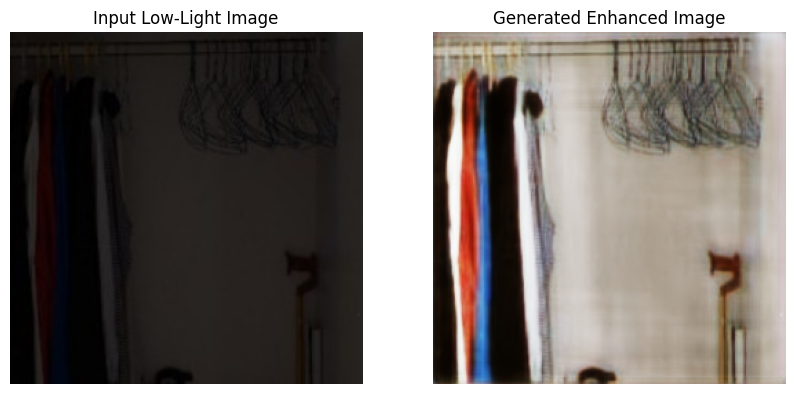

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error as mse
import cv2

# Load the generator and discriminator models
generator = load_model("/content/drive/MyDrive/Colab_Backup/Model Output/gen_model_004000.h5")  # Update the filename accordingly
discriminator = load_model("/content/drive/MyDrive/Colab_Backup/Model Output/disc_model_004000.h5")  # Update the filename accordingly

# Path to the custom low-light image
custom_image_path = "/content/testImage.jpeg"  # Change this to your image path

# Function to preprocess the input image
def preprocess_image(image_path, target_size=(256, 256)):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img = cv2.resize(img, target_size)  # Resize to match training size
    img = (img - 127.5) / 127.5  # Normalize to [-1, 1]
    return np.expand_dims(img, axis=0)  # Add batch dimension

# Load and preprocess the image
input_image = preprocess_image(custom_image_path)

# Generate the enhanced image
generated_image = generator.predict(input_image)

# Post-process the generated image (convert back to [0, 255])
generated_image = (generated_image[0] * 127.5 + 127.5).astype(np.uint8)
input_image_disp = ((input_image[0] * 127.5) + 127.5).astype(np.uint8)

# Ensure images are at least 7x7 before SSIM computation
def ensure_min_size(image, min_size=7):
    h, w, c = image.shape
    if h < min_size or w < min_size:
        image = cv2.resize(image, (max(min_size, w), max(min_size, h)))  # Resize while keeping aspect ratio
    return image

input_image_disp = ensure_min_size(input_image_disp)
generated_image = ensure_min_size(generated_image)

# Evaluate using discriminator
real_label = discriminator.predict([input_image, input_image])  # Real image evaluation
fake_label = discriminator.predict([input_image, np.expand_dims(generated_image, axis=0)])  # Generated image evaluation

# Compute evaluation metrics
psnr_value = psnr(input_image_disp, generated_image)
ssim_value = ssim(input_image_disp, generated_image, win_size=3, channel_axis=-1)  # Set win_size=3
mse_value = mse(input_image_disp.flatten(), generated_image.flatten())

# Print evaluation results
print("\n[Evaluation Metrics]")
print(f"PSNR: {psnr_value:.2f} dB (Higher is better)")
print(f"SSIM: {ssim_value:.4f} (Higher is better, max=1)")
print(f"MSE: {mse_value:.2f} (Lower is better)")
print(f"Discriminator Output on Real Image: {real_label.mean():.4f}")
print(f"Discriminator Output on Generated Image: {fake_label.mean():.4f}")

# Plot input vs. generated image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(input_image_disp)
plt.axis("off")
plt.title("Input Low-Light Image")

plt.subplot(1, 2, 2)
plt.imshow(generated_image)
plt.axis("off")
plt.title("Generated Enhanced Image")

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step

[Evaluation Metrics]
PSNR: 7.29 dB (Higher is better)
SSIM: 0.6590 (Higher is better, max=1)
MSE: 12133.76 (Lower is better)
Discriminator Output on Real Image: 0.7547
Discriminator Output on Generated Image: 0.9190


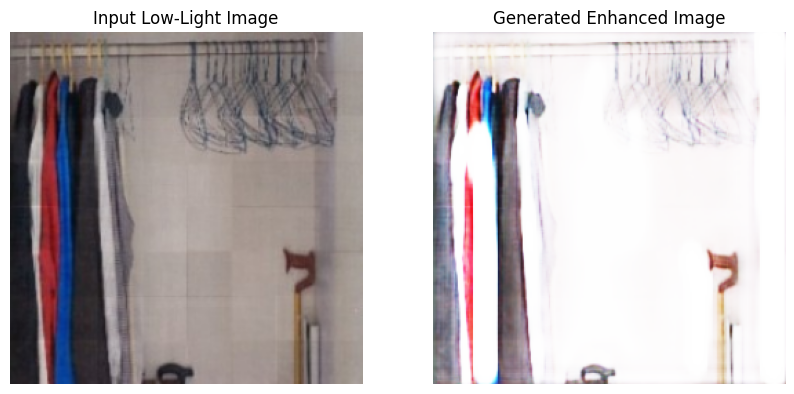

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error as mse
import cv2

# Load the generator and discriminator models
generator = load_model("/content/drive/MyDrive/Colab_Backup/Model Output/gen_model_004000.h5")  # Update the filename accordingly
discriminator = load_model("/content/drive/MyDrive/Colab_Backup/Model Output/disc_model_004000.h5")  # Update the filename accordingly

# Path to the custom low-light image
custom_image_path = "/content/test2Image.jpeg"  # Change this to your image path

# Function to preprocess the input image
def preprocess_image(image_path, target_size=(256, 256)):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img = cv2.resize(img, target_size)  # Resize to match training size
    img = (img - 127.5) / 127.5  # Normalize to [-1, 1]
    return np.expand_dims(img, axis=0)  # Add batch dimension

# Load and preprocess the image
input_image = preprocess_image(custom_image_path)

# Generate the enhanced image
generated_image = generator.predict(input_image)

# Post-process the generated image (convert back to [0, 255])
generated_image = (generated_image[0] * 127.5 + 127.5).astype(np.uint8)
input_image_disp = ((input_image[0] * 127.5) + 127.5).astype(np.uint8)

# Ensure images are at least 7x7 before SSIM computation
def ensure_min_size(image, min_size=7):
    h, w, c = image.shape
    if h < min_size or w < min_size:
        image = cv2.resize(image, (max(min_size, w), max(min_size, h)))  # Resize while keeping aspect ratio
    return image

input_image_disp = ensure_min_size(input_image_disp)
generated_image = ensure_min_size(generated_image)

# Evaluate using discriminator
real_label = discriminator.predict([input_image, input_image])  # Real image evaluation
fake_label = discriminator.predict([input_image, np.expand_dims(generated_image, axis=0)])  # Generated image evaluation

# Compute evaluation metrics
psnr_value = psnr(input_image_disp, generated_image)
ssim_value = ssim(input_image_disp, generated_image, win_size=3, channel_axis=-1)  # Set win_size=3
mse_value = mse(input_image_disp.flatten(), generated_image.flatten())

# Print evaluation results
print("\n[Evaluation Metrics]")
print(f"PSNR: {psnr_value:.2f} dB (Higher is better)")
print(f"SSIM: {ssim_value:.4f} (Higher is better, max=1)")
print(f"MSE: {mse_value:.2f} (Lower is better)")
print(f"Discriminator Output on Real Image: {real_label.mean():.4f}")
print(f"Discriminator Output on Generated Image: {fake_label.mean():.4f}")

# Plot input vs. generated image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(input_image_disp)
plt.axis("off")
plt.title("Input Low-Light Image")

plt.subplot(1, 2, 2)
plt.imshow(generated_image)
plt.axis("off")
plt.title("Generated Enhanced Image")

plt.show()
